In [3]:
# run multiple reps with no dinucleotide present

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyemma as py
import scipy
import sys, os

import math
import glob 

import MDAnalysis as mda
import nglview as ng
from nglview import NGLWidget
import mdtraj as md

from MDAnalysis import transformations

from sklearn.decomposition import PCA

from MDAnalysis.analysis import rms
from MDAnalysis.analysis import distances

In [4]:
# convert each traj -- only need one pdb

#gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc nojump   # solvent-less xtc
#gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000  # solvent-less single pdb

In [2]:

# file path
mj_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/'
pdb =   f'{mj_path}2000ns_310K_gap_BSC1_DNA_rep1/md_nosolv.pdb'
xtc_list = sorted(glob.glob(f'{mj_path}2000ns_310K_gap_BSC1_DNA_rep?/md_nosolv.xtc'))

# load each traj object
traj_list = []
for xtc in xtc_list:
    
    traj = md.load(xtc, top=pdb) 
    print(traj.xyz.shape)
    traj_list.append(traj)


(2389, 817, 3)
(2452, 817, 3)
(2455, 817, 3)
(2006, 817, 3)
(2392, 817, 3)


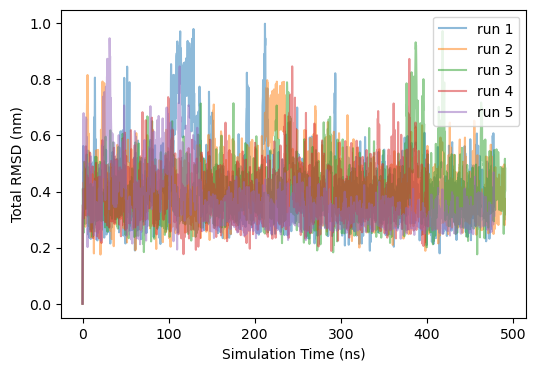

In [3]:
# rmsd look relatively similar:

ts = 0.2 # ns
fig, axes = plt.subplots(figsize=(6, 4))

for i, traj in enumerate(traj_list):

    #rmsd_uncut = md.rmsd(traj_uncut, traj_uncut, frame=0, atom_indices=rmsd_idxs_uncut)
    rmsd = md.rmsd(traj, traj, frame=0)

    axes.plot(np.arange(len(rmsd))*ts, rmsd, alpha=0.5, label=f'run {i+1}')

    axes.legend()
    axes.set_xlabel('Simulation Time (ns)')
    axes.set_ylabel('Total RMSD (nm)')

In [4]:

# load traj
view = NGLWidget() #ng.show_mdtraj(dinuc_cut)

for traj in traj_list[4:5]:
    traj.superpose(reference=traj, frame=0)
    view.add_trajectory(traj, alpha=0.6)
    
    #view.clear_representations()
    #view.add_representation('licorice', selection='not hydrogen', c='blue')

view

NGLWidget(max_frame=2391)

In [5]:
# build a quick PCA

from pyemma.coordinates import featurizer, pca
np.arange(12, 16)

# featurize with residue dists
feat = featurizer(pdb)

pair_list = []
for s1 in np.arange(5, 7):
    for s2 in np.arange(12, 26):
        pair_list.append([s1, s2])
        
feat.add_residue_mindist(residue_pairs=pair_list)

all_feats = []
for traj in traj_list:
    traj_feats = feat.transform(traj)
    all_feats.append(traj_feats)
    print(traj_feats.shape)
    
pca_obj = pca(all_feats, dim=2)
print(pca_obj.cumvar)

pca_traj = pca_obj.get_output()
pca_traj_c = np.concatenate(pca_traj)
print(pca_traj_c.shape)

(2389, 28)
(2452, 28)
(2455, 28)
(2006, 28)
(2392, 28)


calc mean+cov:   0%|                                                                                          …

[0.61343577 0.77246056 0.83405035 0.87897994 0.90549279 0.92934673
 0.94227946 0.95180057 0.95994087 0.96596952 0.97111976 0.97543081
 0.9792828  0.9823033  0.98488376 0.98724764 0.98907582 0.99068456
 0.99227888 0.9936434  0.99494854 0.99619482 0.99728364 0.9981771
 0.99887414 0.99940751 0.99993696 1.        ]


getting output of PCA:   0%|                                                                                  …

(11694, 2)


Text(0, 0.5, 'PC2')

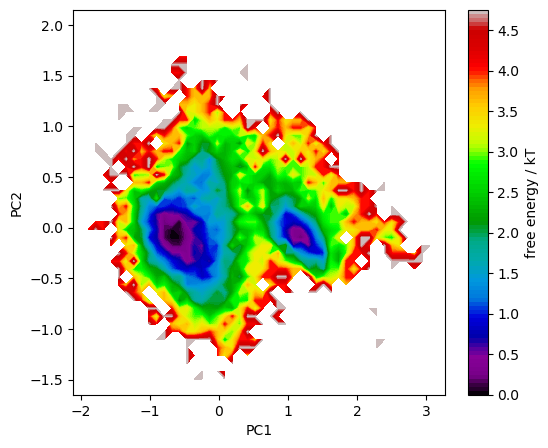

In [9]:
fig, axes = plt.subplots(figsize=(6, 5))
py.plots.plot_free_energy(pca_traj_c[:, 0], pca_traj_c[:, 1], ax=axes, nbins=50)
axes.set_xlabel('PC1')
axes.set_ylabel('PC2')

In [ ]:
c_list = ['blue', 'orange', 'green', 'red', 'purple']

for i, pt in enumerate(pca_traj):
    plt.scatter(pt[:, 0], pt[:, 1], s=1, c=c_list[i], alpha=0.4, label=f'run{i+1}')
    plt.scatter(pt[-1, 0], pt[-1, 1], c=c_list[i], alpha=1, label=f'run{i+1}')
    #plt.scatter(pca_traj_c[0, 0], pca_traj_c[0, 1], c='red')
    plt.legend()
    
# plot as free energy

In [14]:
# print trjconv commands for each new job

# file path
mj_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/'

# list of different gap sizes
gap_list = [ 'gap_AAA_B', 'gap_AAAA_B']

cmd_list = []
for gap in gap_list:
    job_list = sorted(glob.glob(f'{mj_path}*{gap}*/'))
    for job_dir in job_list:
        cmd_list.append(f'cd {job_dir}')
        cmd_list.append('echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc nojump')
        cmd_list.append('echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000')
        cmd_list.append('\n')
        
for cmd in cmd_list:
    print(cmd)

cd /project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_AAA_BSC1_DNA_/
echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc nojump
echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000


cd /project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_AAA_BSC1_DNA_rep1/
echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc nojump
echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000


cd /project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_AAA_BSC1_DNA_rep2/
echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc nojump
echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000


cd /project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_AAA_BSC1_DNA_rep3/
echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc nojump
echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000


cd /project/andrewferguson/Smayan/aa_oligos/jobs_MJ/

In [7]:
## end to end distance for each gap

from pyemma.coordinates import featurizer

# file path
mj_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/'

# list of different gap sizes
gap_list = ['gap_B', 'gap_AAA_B', 'gap_AAAA_B']
gap_names = ['AA', 'AAA', 'AAAA']

nbp_list = [14, 15, 16]
ngap_list = [2, 3, 4]
c5 = 566
c3_list = [630, 662, 694]

# collect groups of all trajectories
all_trajs, all_feats = [], []

for gap, nbp, ngap, c3 in zip(gap_list, nbp_list, ngap_list, c3_list):
    print(gap, nbp, ngap)
    
    pdb = glob.glob(f'{mj_path}*{gap}*/md_nosolv.pdb')[0]
    xtc_list = sorted(glob.glob(f'{mj_path}*{gap}*/md_nosolv.xtc'))
    print(pdb)

    # featurize with residue dists
    feat = featurizer(pdb)
    #pair_list = [[0, nbp-ngap-1], [5, 6], [nbp-ngap, nbp*2-ngap-1], [nbp-ngap+5, nbp+6]]
    pair_list = [[nbp-ngap+5, nbp+6]]
    feat.add_residue_mindist(residue_pairs=pair_list)
    feat.add_minrmsd_to_ref(pdb, ref_frame=0)
    feat.add_minrmsd_to_ref(pdb, ref_frame=0, atom_indices=np.arange(c5, c3))

    # load each traj object
    traj_list, feat_list = [], []
    for xtc in xtc_list:

        traj = md.load(xtc, top=pdb) 
        print(xtc, traj.xyz.shape)
        traj_list.append(traj)

        feats = feat.transform(traj)
        feat_list.append(feats)
        print(np.shape(feats)) 
        
    all_trajs.append(traj_list)
    all_feats.append(feat_list)

gap_B 14 2
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_BSC1_DNA_rep1/md_nosolv.pdb
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_BSC1_DNA_rep1/md_nosolv.xtc (2389, 817, 3)
(2389, 3)
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_BSC1_DNA_rep2/md_nosolv.xtc (2452, 817, 3)
(2452, 3)
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_BSC1_DNA_rep3/md_nosolv.xtc (2455, 817, 3)
(2455, 3)
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_BSC1_DNA_rep4/md_nosolv.xtc (2006, 817, 3)
(2006, 3)
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_BSC1_DNA_rep5/md_nosolv.xtc (2392, 817, 3)
(2392, 3)
gap_AAA_B 15 3
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_AAA_BSC1_DNA_/md_nosolv.pdb
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_AAA_BSC1_DNA_/md_nosolv.xtc (2192, 849, 3)
(2192, 3)
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/2000ns_310K_gap_AAA_BSC1_DNA_re

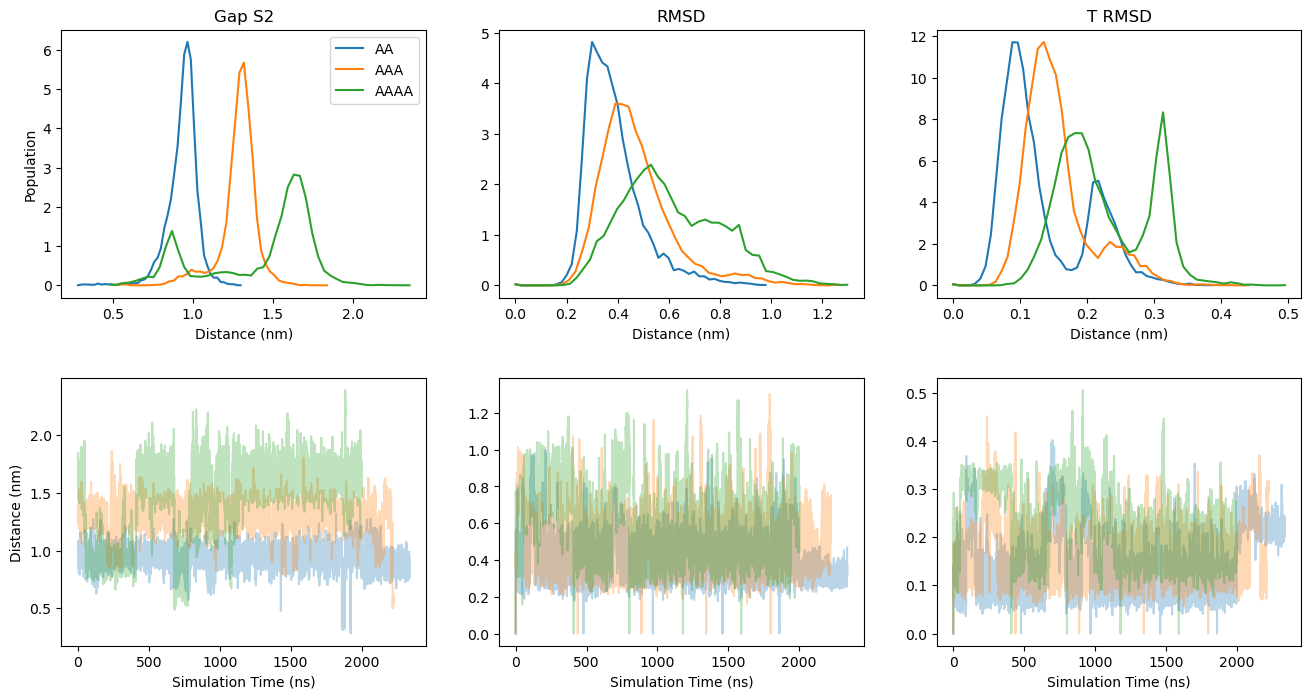

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
nbins = 50

#cv_labels = ['End-to-end S1', 'Gap S1', 'End-to-end S2', 'Gap S2', 'RMSD']
cv_labels = ['Gap S2','RMSD', 'T RMSD']

for j, (traj_list, feat_list, gap_name) in enumerate(zip(all_trajs, all_feats, gap_names)):
    
    feats = np.concatenate(feat_list)
    for i, (cv, ax) in enumerate(zip(cv_labels, axes.T)):
        
        # plot hist of concatenated feats
        h, b = np.histogram(feats[:, i], bins=50, density=True)
        ax[0].plot(b[:-1], h, label=gap_name)
        ax[0].set_title(cv)
        ax[0].set_xlabel('Distance (nm)')
        
        # plot feats over time
        x = 0.2 * np.arange(len(feats[:, i]))
        ax[1].plot(x, feats[:, i], alpha=0.3)
        ax[1].set_xlabel('Simulation Time (ns)')
    
axes[0, 0].set_ylabel('Population')
axes[1, 0].set_ylabel('Distance (nm)')
axes[0, 0].legend()
plt.subplots_adjust(hspace=0.3)

In [ ]:
# plot rmsd of each traj



In [16]:
# visualize

job_dir = f'{mj_path}2000ns_310K_gap_BSC1_DNA_rep1/'
pdb = f'{job_dir}md_nosolv.pdb'
xtc = f'{job_dir}md_nosolv.xtc'

view = NGLWidget() #ng.show_mdtraj(dinuc_cut)

traj = md.load(xtc, top=pdb) 
traj.superpose(reference=traj, frame=0)

view.add_trajectory(traj)
view.clear_representations()
view.add_representation('licorice', selection='not hydrogen')

view

NGLWidget(max_frame=2388)

### AAA 
- rep 3 - 130 closes gap for a while
- rep 3 - 2270 full bend down
- rep 0 - 173 flipped

### AAAA
- rep 0 - full traj stays stuck in right angle
- rep 1 - 1640 right angle and stays stuck again
- rep 2 - finds state a couple times but breaks free
- rep 3 - 1965 backflips, no metastable states
- rep 4 - 2053 bent, metastable state?